# Imports and setup

In [ ]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config

config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jaxopt

import arviz as az
import numpyro

numpyro.enable_x64()
numpyro.set_host_device_count(2)
#from numpyro_ext.optim import optimize
from numpyro import infer

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

import sys
sys.path.append('../../stream-membership')
sys.path.append('../')
sys.path.append('../../cats/')
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)

mpl.rcParams['image.cmap'] = 'magma'

A new version of galpy (1.9.0) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [ ]:
import importlib
importlib.reload(sys.modules['gd1_helpers.membership'])
importlib.reload(sys.modules['stream_membership'])
from gd1_helpers.membership import (
    GD1Base,
    GD1BackgroundModel,
    GD1StreamModel,
    GD1OffTrackModel,
)
from stream_membership import StreamMixtureModel
from stream_membership.plot import plot_data_projections

In [ ]:
# data = at.Table.read("../../cats/data/joined-GD-1.fits")

data = at.Table.read('/mnt/home/apricewhelan/projects/gd1-dr3/data/tmp/run_data.fits')
#masks = at.Table.read('/mnt/home/apricewhelan/projects/gd1-dr3/data/tmp/run_data_masks.fits')
print(len(data))

#cat = data
# cat['pm1'] = cat['pm_phi1_cosphi2_unrefl']
# cat['pm2'] = cat['pm_phi2_unrefl']

In [ ]:
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

stream='GD-1'


p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=3)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, hb_mask, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

In [ ]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [ ]:
# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint, pm_mask = rough_pm_poly(p, cat, buffer=2)
p.pmprint.vertices

In [ ]:
GD1Base.default_grids['phi2'] = np.linspace(-8,4, 100)
GD1Base.default_grids['pm1'] = np.linspace(-15,-1, 100)
GD1Base.default_grids['pm2'] = np.linspace(-7,7, 100)

In [ ]:
GD1Base.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
GD1Base.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
GD1Base.default_grids['phi2'] = np.linspace(-7,3, 100)

GD1Base.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
GD1Base.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
GD1Base.coord_bounds['phi2'] = (-7,3)



GD1BackgroundModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
GD1BackgroundModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)
GD1BackgroundModel.default_grids['phi2'] = np.linspace(-7,3, 100)

GD1BackgroundModel.coord_bounds['pm1'] = (np.min(p.pmprint.vertices[:,0]), np.max(p.pmprint.vertices[:,0]))
GD1BackgroundModel.coord_bounds['pm2'] = (np.min(p.pmprint.vertices[:,1]), np.max(p.pmprint.vertices[:,1]))
GD1BackgroundModel.coord_bounds['phi2'] = (-7,3)

GD1StreamModel.default_grids['pm1'] = np.linspace(p.pmprint.vertices[0,0], p.pmprint.vertices[-1,0], 100)
GD1StreamModel.default_grids['pm2'] = np.linspace(p.pmprint.vertices[0,1], p.pmprint.vertices[1,1], 100)

In [ ]:
GD1BackgroundModel.coord_bounds

In [ ]:
run_data_ = o.cat[pm_mask & (iso_mask | hb_mask)]
#run_data_ = o.cat[(iso_mask | hb_mask)]
run_data = {k: np.array(run_data_[k], dtype="f8") for k in run_data_.colnames}


bkg_data_ = o.cat[pm_mask & (iso_mask | hb_mask) & ~o.on_skymask]
#bkg_data_ = o.cat[~o.on_skymask]
bkg_data = {k: np.array(bkg_data_[k], dtype="f8") for k in bkg_data_.colnames}

In [ ]:
len(bkg_data['phi1'])

In [ ]:
# run_data = {k: np.array(data[k], dtype="f8") for k in data.colnames}
# bkg_data = {k: np.array(data[~masks['sky_track']][k], dtype="f8") for k in data.colnames}
# len(bkg_data['phi1'])

In [ ]:
plot_data_projections(data=bkg_data, grids=GD1BackgroundModel.default_grids,
                      smooth=1);

# Background

In [15]:
phi1_dens, _ = np.histogram(
    bkg_data["phi1"],
    bins=(GD1BackgroundModel.phi1_locs.shape[0]-1), density=True)


phi1_dens

array([0.0048675 , 0.00675792, 0.00947943, 0.01184977, 0.01155128,
       0.01038659, 0.00700373, 0.00477971])

In [30]:
xdata.shape

(31,)

(0.0, 10000.0)

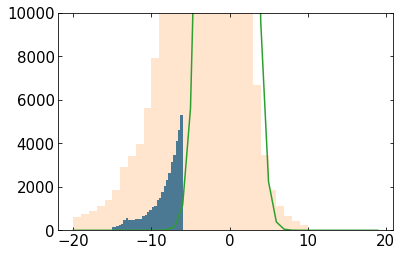

In [97]:
xs = np.arange(-20, 20)

ydata, xdata, im = plt.hist(run_data['pm1'], bins = 30)
ydata, xdata, im = plt.hist(o.cat[(iso_mask | hb_mask)]['pm1'], bins = 30, range=[-20,10], alpha=0.2)
plt.plot(xs, out[0][0]*np.exp(-0.5*((xs-out[0][1])/out[0][2])**2))#+out[0][3])
plt.ylim(0, 10000)

In [94]:
from scipy.optimize import leastsq

fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2)
errfunc  = lambda p, x, y: (y - fitfunc(p, x))

init = [1e6, 0, 2]
out   = leastsq( errfunc, init, args=(xdata[1:], ydata))

out

(array([ 1.58236463e+05, -3.01732893e-01,  1.81724000e+00]), 1)

In [95]:
np.log(1.8)

0.5877866649021191

In [65]:
bkg_init_p = {
    "ln_N": np.log(len(run_data['phi1'])),
    "phi1": {"zs": np.zeros(GD1BackgroundModel.phi1_locs.shape[0]-1)},
    "phi2": {},
    "pm1": {
        "w": np.full_like(GD1BackgroundModel.pm1_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm1_knots, 40),
        "ln_std1": np.full_like(GD1BackgroundModel.pm1_knots, 2.3),
        "mean2": np.full_like(GD1BackgroundModel.pm1_knots, 5.),
        "ln_std2": np.full_like(GD1BackgroundModel.pm1_knots, 2.)
    },
    "pm2": {
        "w": np.full_like(GD1BackgroundModel.pm2_knots, 0.5),
        "mean1": np.full_like(GD1BackgroundModel.pm2_knots, -2.),
        "ln_std1": np.full_like(GD1BackgroundModel.pm2_knots, 1.),
        "mean2": np.full_like(GD1BackgroundModel.pm2_knots, -2.5),
        "ln_std2": np.full_like(GD1BackgroundModel.pm2_knots, 1.5)
    },
}
background_init = GD1BackgroundModel(bkg_init_p)

In [66]:
GD1BackgroundModel._get_jaxopt_bounds()

({'ln_N': -10,
  'phi1': {'zs': Array([-8., -8., -8., -8., -8., -8., -8., -8.], dtype=float64, weak_type=True)},
  'phi2': {},
  'pm1': {'w': Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64, weak_type=True),
   'mean1': Array([-7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7],      dtype=int64, weak_type=True),
   'ln_std1': Array([-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3],      dtype=int64, weak_type=True),
   'mean2': Array([-7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7, -7],      dtype=int64, weak_type=True),
   'ln_std2': Array([-3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3],      dtype=int64, weak_type=True)},
  'pm2': {'w': Array([0, 0, 0, 0, 0, 0, 0], dtype=int64, weak_type=True),
   'mean1': Array([-5, -5, -5, -5, -5, -5, -5], dtype=int64, weak_type=True),
   'ln_std1': Array([-3, -3, -3, -3, -3, -3, -3], dtype=int64, weak_type=True),
   'mean2': Array([-5, -5, -5, -5, -5, -5, -5], dtype=int64, weak_type=True),
   'ln_std2': Array([-3, -3, -3, -3, -

In [67]:
bkg_init_p

{'ln_N': 10.660125830877272,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {},
 'pm1': {'w': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
  'mean1': array([40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40., 40.]),
  'ln_std1': array([2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3]),
  'mean2': array([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]),
  'ln_std2': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])},
 'pm2': {'w': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
  'mean1': array([-2., -2., -2., -2., -2., -2., -2.]),
  'ln_std1': array([1., 1., 1., 1., 1., 1., 1.]),
  'mean2': array([-2.5, -2.5, -2.5, -2.5, -2.5, -2.5, -2.5]),
  'ln_std2': array([1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5])}}

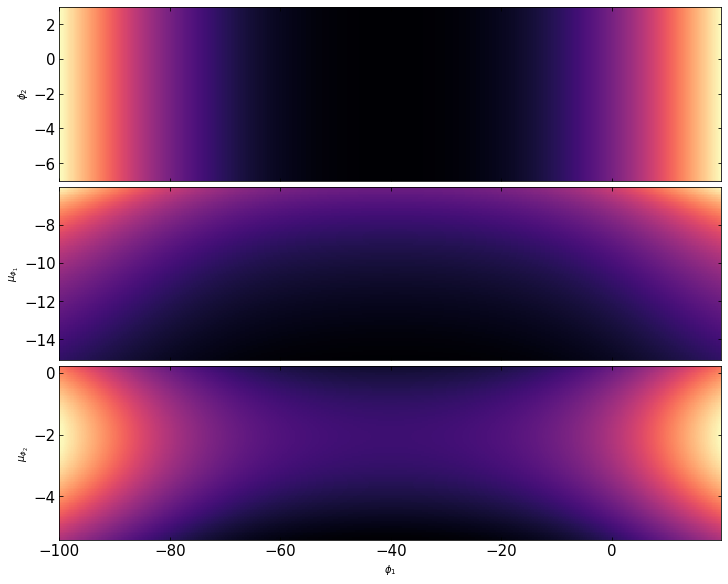

In [68]:
_ = background_init.plot_model_projections()

In [69]:
bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
    data=bkg_data,
    init_params=bkg_init_p,
    use_bounds=True,
    jaxopt_kwargs=dict(maxiter=4096),
)
background_opt = GD1BackgroundModel(bkg_opt_pars)
bkg_info

ScipyMinimizeInfo(fun_val=Array(2.59957353, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]))

In [70]:
bkg_opt_pars

{'ln_N': Array(10.49532844, dtype=float64),
 'phi1': {'zs': Array([-0.22173282, -0.17897061, -0.06209499,  0.13641748,  0.28523594,
          0.2533887 ,  0.12946386,  0.0401676 ], dtype=float64)},
 'phi2': {},
 'pm1': {'ln_std1': Array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float64),
  'ln_std2': Array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.], dtype=float64),
  'mean1': Array([19.99897303, 19.99597386, 19.99672632, 19.99486601, 19.99436726,
         19.99368948, 19.99366374, 19.99415857, 19.99439357, 19.99478363,
         19.99678198, 19.99605313, 19.99910282], dtype=float64),
  'mean2': Array([4.9990343 , 4.99609602, 4.9968752 , 4.99524652, 4.99438274,
         4.99262781, 4.99184603, 4.99207259, 4.99254646, 4.99341783,
         4.99630891, 4.99565597, 4.99903813], dtype=float64),
  'w': Array([0.39787256, 0.2825981 , 0.23954395, 0.16807   , 0.0972429 ,
         0.02403033, 0.        , 0.0258399 , 0.05279933, 0.11549802,
         0.22114221, 0.271546 

In [71]:
bkg_opt_pars['pm1']['w']

Array([0.39787256, 0.2825981 , 0.23954395, 0.16807   , 0.0972429 ,
       0.02403033, 0.        , 0.0258399 , 0.05279933, 0.11549802,
       0.22114221, 0.271546  , 0.40318848], dtype=float64)

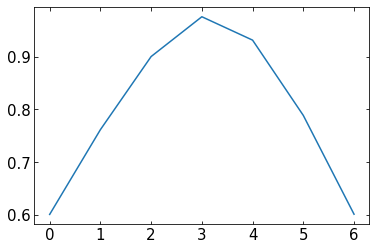

In [72]:
plt.plot(bkg_opt_pars['pm2']['w'])

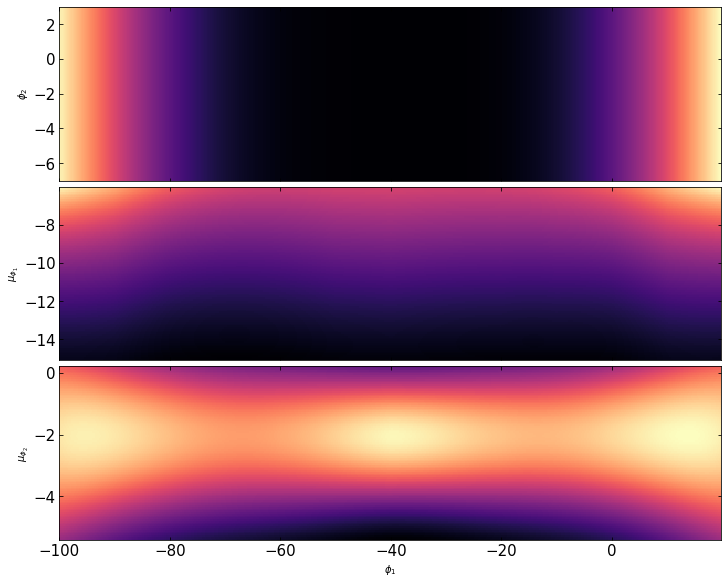

In [73]:
_ = background_opt.plot_model_projections()

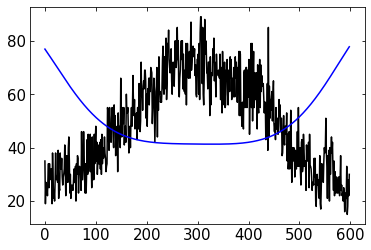

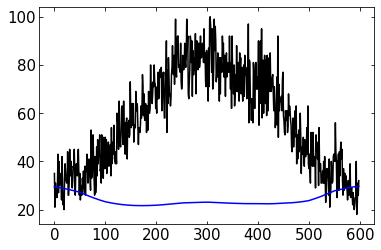

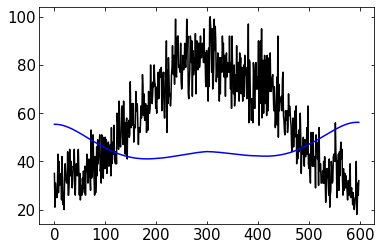

In [99]:
H_data1, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["phi2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['phi2'])
)
H_data2, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["pm1"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['pm1'])
)
H_data3, *_ = np.histogram2d(
    bkg_data["phi1"],
    bkg_data["pm2"],
    bins=(background_opt.default_grids["phi1"], background_opt.default_grids['pm2'])
)
grids, ln_ns = background_opt.evaluate_on_2d_grids()

plt.figure(figsize=(6, 4))
plt.plot(H_data1.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'phi2')]).sum(axis=0), c='b')

plt.figure(figsize=(6, 4))
plt.plot(H_data2.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'pm1')]).sum(axis=0), c='b')

plt.figure(figsize=(6, 4))
plt.plot(H_data3.T.sum(axis=0), c='k')
plt.plot(np.exp(ln_ns[('phi1', 'pm2')]).sum(axis=0), c='b')

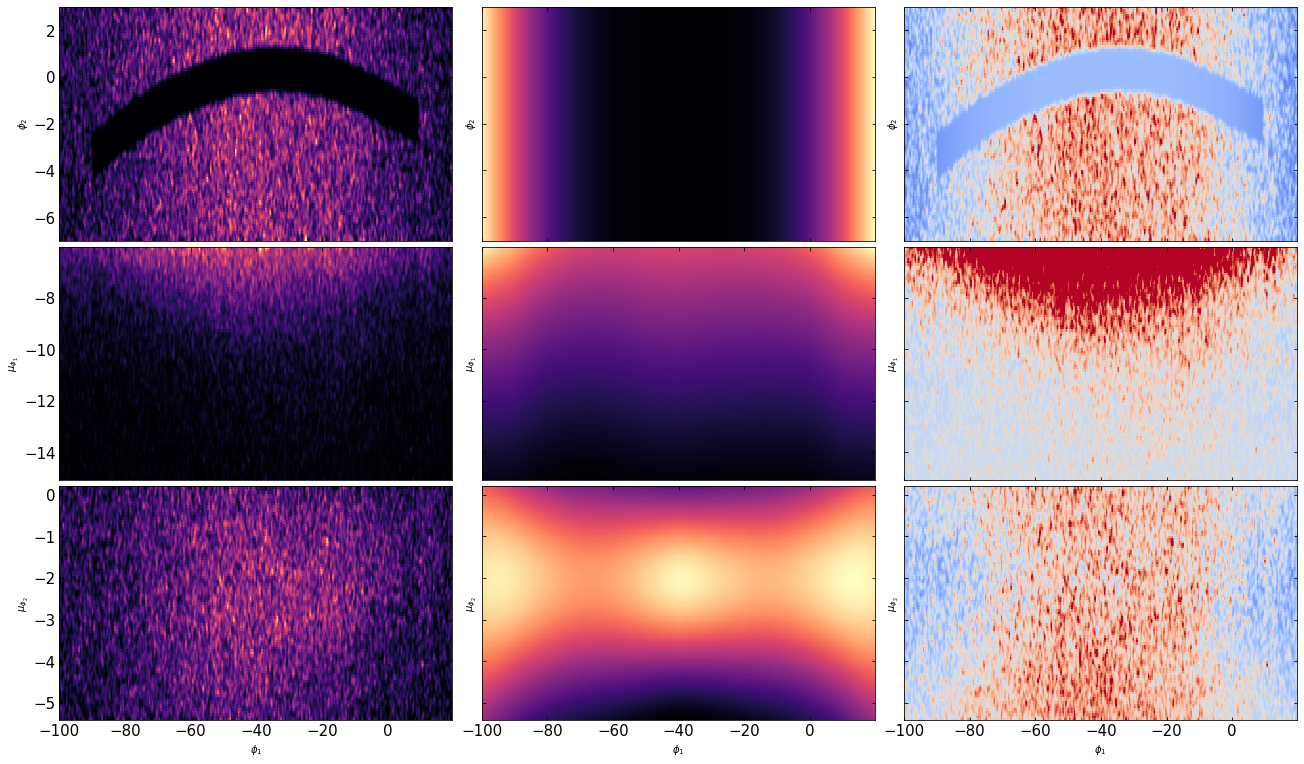

In [76]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3,
    figsize=(18, 3.5 * (len(background_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=bkg_data,
    grids=GD1BackgroundModel.default_grids,
    axes=axes[:, 0],
    # coord_names=GD1BackgroundModel.coord_names,
)
background_opt.plot_model_projections(axes=axes[:, 1])
background_opt.plot_residual_projections(
    data=bkg_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Stream

In [196]:
# TODO: replace this with galstreams initialization
from scipy.stats import binned_statistic
from scipy.interpolate import InterpolatedUnivariateSpline

#stream_mask = masks["sky_track"] & masks["pm_rough"]
stream_data_ = o.cat[pmsel.pm12_mask & (iso_mask | hb_mask) & o.on_skymask]
#stream_data = {k: v[stream_mask] for k, v in stream_data_.items()}
stream_data = {k: np.array(stream_data_[k], dtype="f8") for k in stream_data_.colnames}

_phi2_stat = binned_statistic(stream_data["phi1"], stream_data["phi2"], bins=np.linspace(-90, 10, 21))
_phi2_interp = InterpolatedUnivariateSpline(
    0.5 * (_phi2_stat.bin_edges[:-1] + _phi2_stat.bin_edges[1:]), _phi2_stat.statistic
)

_pm1_stat = binned_statistic(stream_data["phi1"], stream_data["pm1"], bins=np.linspace(-80, 0, 32))
_pm1_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm1_stat.bin_edges[:-1] + _pm1_stat.bin_edges[1:]), _pm1_stat.statistic, ext=3
)

_pm2_stat = binned_statistic(stream_data["phi1"], stream_data["pm2"], bins=np.linspace(-80, 0, 32))
_pm2_interp = InterpolatedUnivariateSpline(
    0.5 * (_pm2_stat.bin_edges[:-1] + _pm2_stat.bin_edges[1:]), _pm2_stat.statistic, ext=3
)

In [197]:
_pm1_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi1_cosphi2,
                                         ext=3)
_pm2_interp=InterpolatedUnivariateSpline(p.track.track.transform_to(p.track.stream_frame).phi1,
                                         p.track.track.transform_to(p.track.stream_frame).pm_phi2,
                                         ext=3)

In [198]:
np.e**10

22026.465794806703

In [199]:
stream_init_p = {
    "ln_N": np.log(len(stream_data['phi1'])),
    "phi1": {
        "zs": np.zeros(GD1StreamModel.phi1_locs.shape[0]-1)
    },
    "phi2": {
        "mean": _phi2_interp(GD1StreamModel.phi2_knots),
        "ln_std": np.full_like(GD1StreamModel.phi2_knots, -0.5)
    },
    "pm1": {
        "mean": _pm1_interp(GD1StreamModel.pm1_knots),
        "ln_std": np.full_like(GD1StreamModel.pm1_knots, -1)
    },
    "pm2": {
        "mean": _pm2_interp(GD1StreamModel.pm2_knots),
        "ln_std": np.full_like(GD1StreamModel.pm2_knots, -1)
    }
}

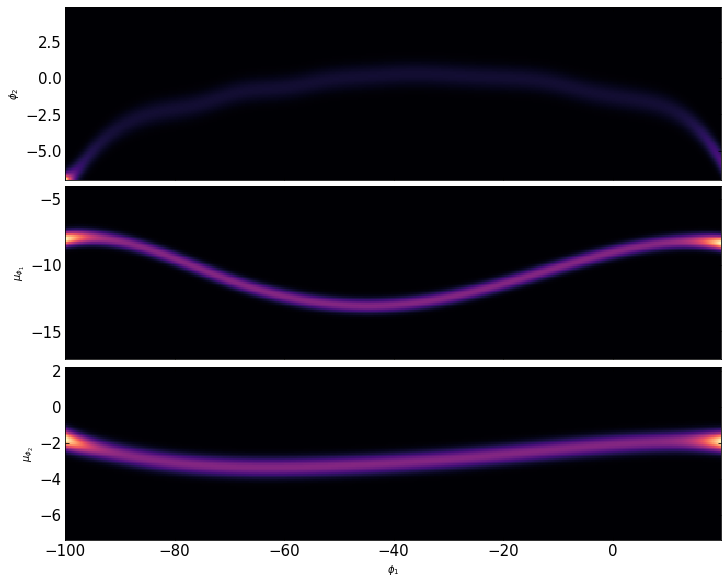

In [200]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [201]:
stream_init_p

{'ln_N': 7.330405211844402,
 'phi1': {'zs': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])},
 'phi2': {'mean': array([-7.88163477, -3.95341163, -2.42211648, -1.84441857, -0.95850907,
         -0.65285416, -0.1239385 ,  0.14401882,  0.29575805,  0.15567152,
          0.0156095 , -0.25665396, -0.97954984, -1.47919275, -2.45582047,
         -5.90023171]),
  'ln_std': array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
         -0.5, -0.5, -0.5, -0.5, -0.5])},
 'pm1': {'mean': array([ -8.01001683,  -8.77103682, -11.15172534, -12.76884806,
         -13.02597314, -11.97714148, -10.18789348,  -8.59629564,
          -8.319378  ]),
  'ln_std': array([-1., -1., -1., -1., -1., -1., -1., -1., -1.])},
 'pm2': {'mean': array([-1.80139711, -3.24562547, -3.27612746, -2.78970843, -2.09902309,
         -1.99723637]),
  'ln_std': array([-1., -1., -1., -1., -1., -1.])}}

In [202]:
stream_opt_pars, info = GD1StreamModel.optimize(
    data=stream_data, init_params=stream_init_p, use_bounds=True
)
stream_opt = GD1StreamModel(stream_opt_pars)
info

ScipyMinimizeInfo(fun_val=Array(-0.70121455, dtype=float64, weak_type=True), success=True, status=0, iter_num=948, hess_inv=LbfgsInvHessProduct(sk=[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  7.12444592e-05  1.15912023e-04
  -4.11806358e-04 -3.08258798e-06  3.12536600e-04  5.20739987e-04
  -1.56488154e-04 -1.16033348e-05  2.08631559e-04  2.83054139e-05
  -3.31902311e-04 -4.49643708e-05  1.36171899e-05 -1.84241189e-04
  -4.63823726e-05 -4.67812304e-04 -5.39482336e-04  6.97212649e-05
   5.80945881e-05 -5.85459822e-04 -2.70417207e-04  0.00000000e+00
   1.99812507e-04  8.99373808e-05  2.10908627e-05  3.53583625e-06
   3.80426351e-07  7.45146247e-05  1.89953641e-05  7.04911538e-05
  -4.46152029e-07  1.98672567e-05 -5.35569311e-06  1.90893192e-05
   3.61888890e-05  7.21096489e-06  6.05582650e-07  4.53079943e-05
   4.80289059e-05 -8.42180797e-06 -2.19351860e-05 -1.05525166e-05
  -4.39214413e-05  3.81711565e-05  1.20218667e-05 -5.02387495

Text(0, 0.5, '$\\phi_2$')

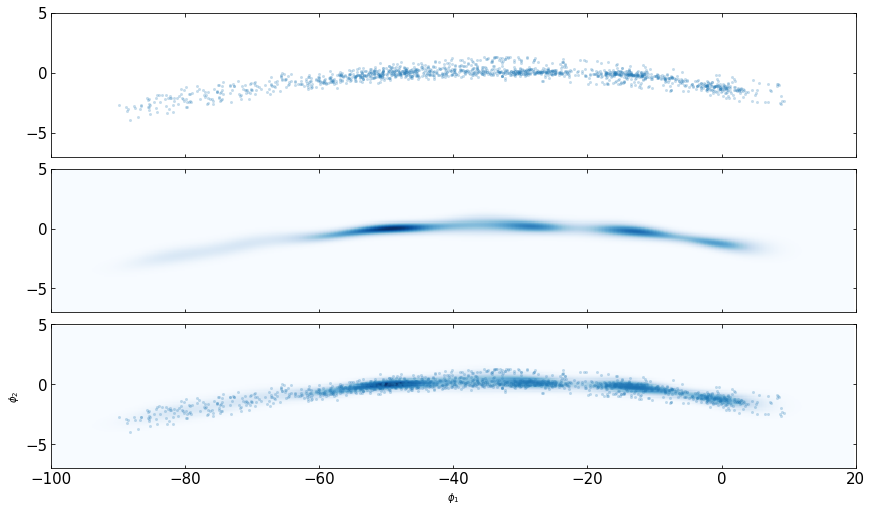

In [203]:
# _grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_2d_grids()
_grids, ln_dens = stream_opt.evaluate_on_2d_grids()

fig, axes = plt.subplots(3, 1, figsize=(12, 7), constrained_layout=True, sharex=True, sharey=True)

for ax in [axes[0], axes[2]]:
    ax.plot(
        stream_data['phi1'],
        stream_data['phi2'],
        marker="o",
        markeredgewidth=0,
        markersize=3.0,
        ls="none",
        alpha=0.25,
    )
    
for ax in [axes[1], axes[2]]:
    ax.pcolormesh(
        _grids[('phi1', 'phi2')][0],
        _grids[('phi1', 'phi2')][1],
        np.exp(ln_dens[('phi1', 'phi2')]),
        cmap="Blues",
        shading='auto'
    )
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

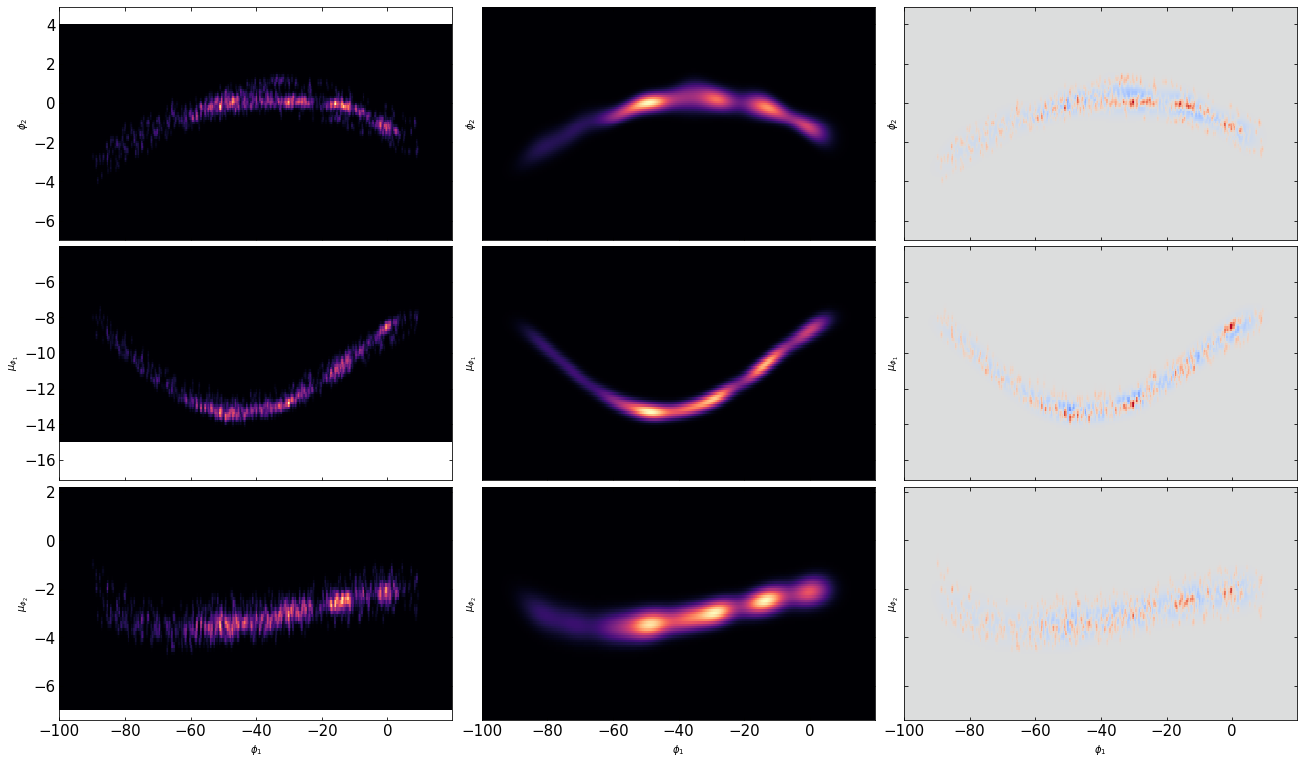

In [204]:
fig, axes = plt.subplots(
    len(background_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=stream_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
stream_opt.plot_model_projections(axes=axes[:, 1])
stream_opt.plot_residual_projections(
    data=stream_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Mixture of Stream + Background (no off-track)

In [205]:
Components = [GD1StreamModel, GD1BackgroundModel]
mix_params0 = {"stream": stream_opt_pars, "background": bkg_opt_pars}

In [206]:
mix_init = StreamMixtureModel(mix_params0, Components)

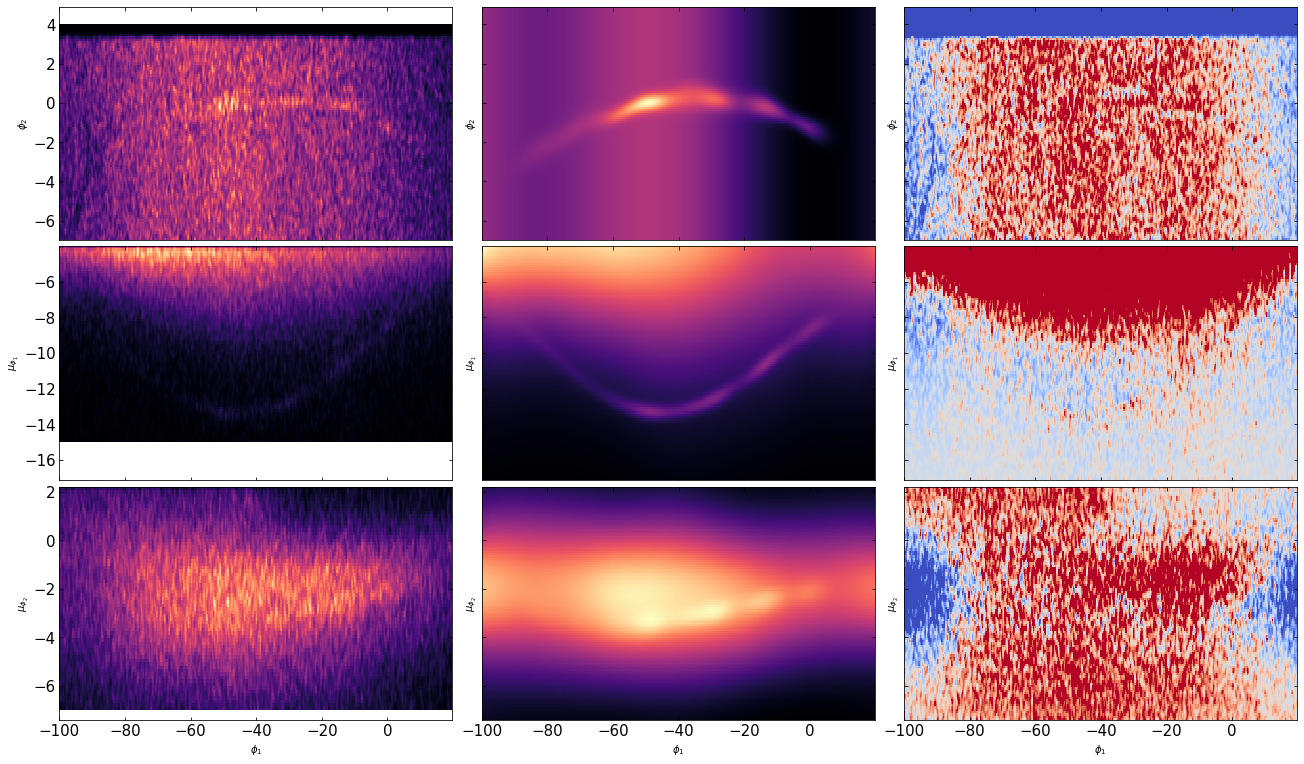

In [207]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_init.plot_model_projections(axes=axes[:, 1])
mix_init.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

In [208]:
mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data, Components=Components, init_params=mix_params0, use_bounds=True
)
mix_opt = StreamMixtureModel(mix_opt_pars, Components=Components)
info

ScipyMinimizeInfo(fun_val=Array(1.11735319, dtype=float64, weak_type=True), success=False, status=2, iter_num=2, hess_inv=LbfgsInvHessProduct(sk=[], yk=[]))

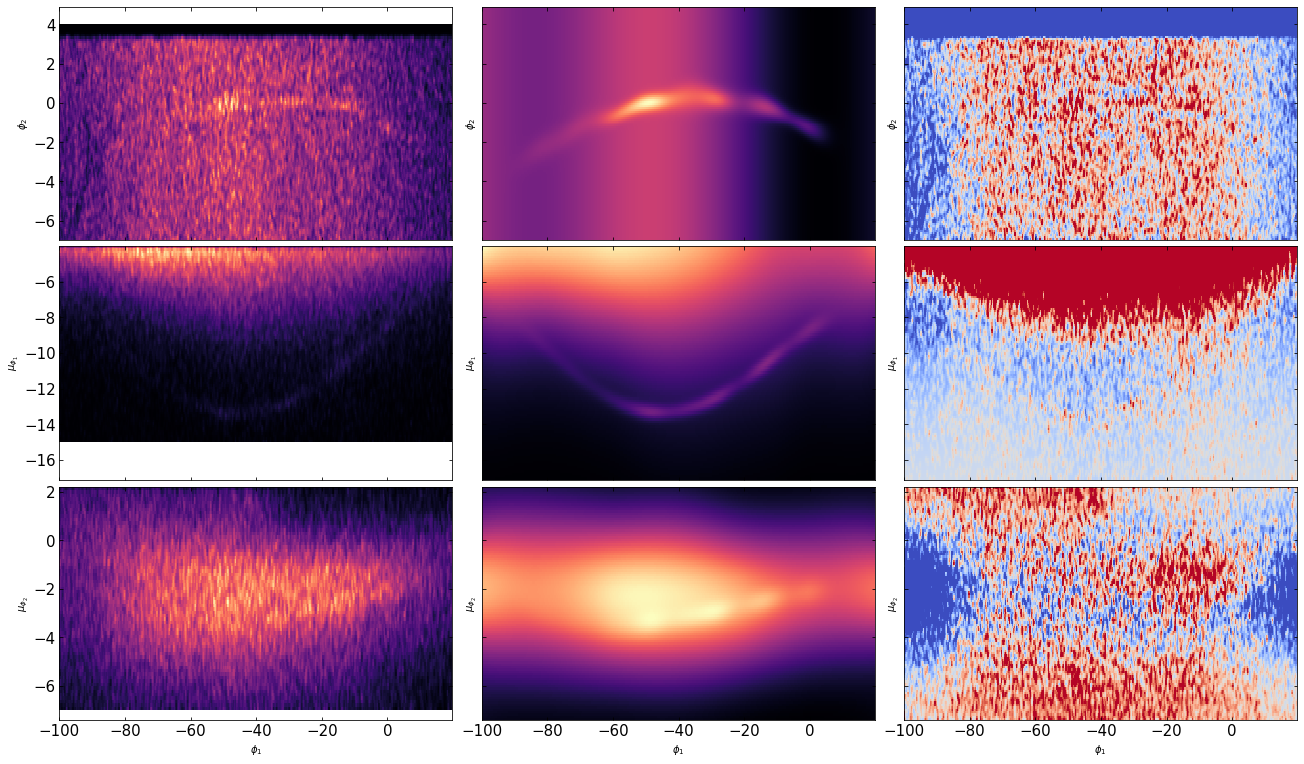

In [209]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
mix_opt.plot_model_projections(axes=axes[:, 1])
mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")

# Off-track

In [211]:
offtrack_init_p = {
    "ln_N": np.log(100),
    ("phi1", "phi2"): {
        "zs": np.zeros(GD1OffTrackModel.phi12_locs.shape[0] - 1)
    },
    "pm1": stream_opt_pars["pm1"].copy(),
    "pm2": stream_opt_pars["pm2"].copy()
}

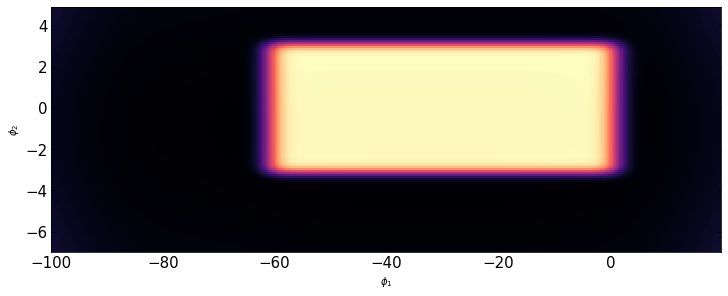

In [212]:
offtrack_model0 = GD1OffTrackModel(offtrack_init_p)
_ = offtrack_model0.plot_model_projections(grid_coord_names=[('phi1', 'phi2')])

# Mixture of all components

In [213]:
full_Components = [GD1StreamModel, GD1BackgroundModel, GD1OffTrackModel]
full_mix_params0 = {
    "stream": stream_opt_pars,
    "background": bkg_opt_pars,
    "offtrack": offtrack_init_p,
}

In [214]:
full_mix_init = StreamMixtureModel(
    full_mix_params0,
    full_Components,
    tied_params=[
        (("offtrack", "pm1"), ("stream", "pm1")),
        (("offtrack", "pm2"), ("stream", "pm2")),
    ],
)

In [ ]:
full_mix_opt_pars, info = StreamMixtureModel.optimize(
    data=run_data,
    Components=full_Components,
    tied_params=tied_params,
    init_params=full_mix_params0,
    use_bounds=True,
)
full_mix_opt = StreamMixtureModel(full_mix_opt_pars, Components=full_Components)
info

In [ ]:
tmp_pars = copy.deepcopy(full_mix_opt_pars['offtrack'])
tmp_pars['pm1'] = full_mix_opt_pars['stream']['pm1'].copy()
tmp_pars['pm2'] = full_mix_opt_pars['stream']['pm2'].copy()
tmp = GD1OffTrackModel(tmp_pars)
tmp.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(vmin=0, vmax=0.4, cmap='magma_r')
)

In [ ]:
full_mix_nobkg_opt = StreamMixtureModel(
    full_mix_opt_pars, Components=[GD1StreamModel, GD1OffTrackModel], tied_params=tied_params
)
full_mix_nobkg_opt.plot_model_projections(
    grid_coord_names=[("phi1", "phi2")], pcolormesh_kwargs=dict(norm=mpl.colors.LogNorm(vmin=1e-2, vmax=1), cmap='Greys')
)

In [ ]:
full_stream_opt = GD1StreamModel(full_mix_opt_pars['stream'])
full_stream_opt.plot_model_projections(pcolormesh_kwargs=dict(vmin=0, vmax=0.5))

In [217]:
full_mix_opt_pars['stream']['pm1']

{'ln_std': Array([-0.86541515, -0.91688066, -1.06186763, -1.15438145, -1.25354065,
        -1.14996269, -1.09284736, -0.96356562, -0.96085753], dtype=float64),
 'mean': Array([ -8.23973304,  -9.00712161, -11.39111032, -13.03184141,
        -13.23629789, -12.15145871, -10.11117072,  -8.23814473,
         -8.53670427], dtype=float64)}

TODO: how to plot projections for components where the x coord is in a joint, like OffTrack?

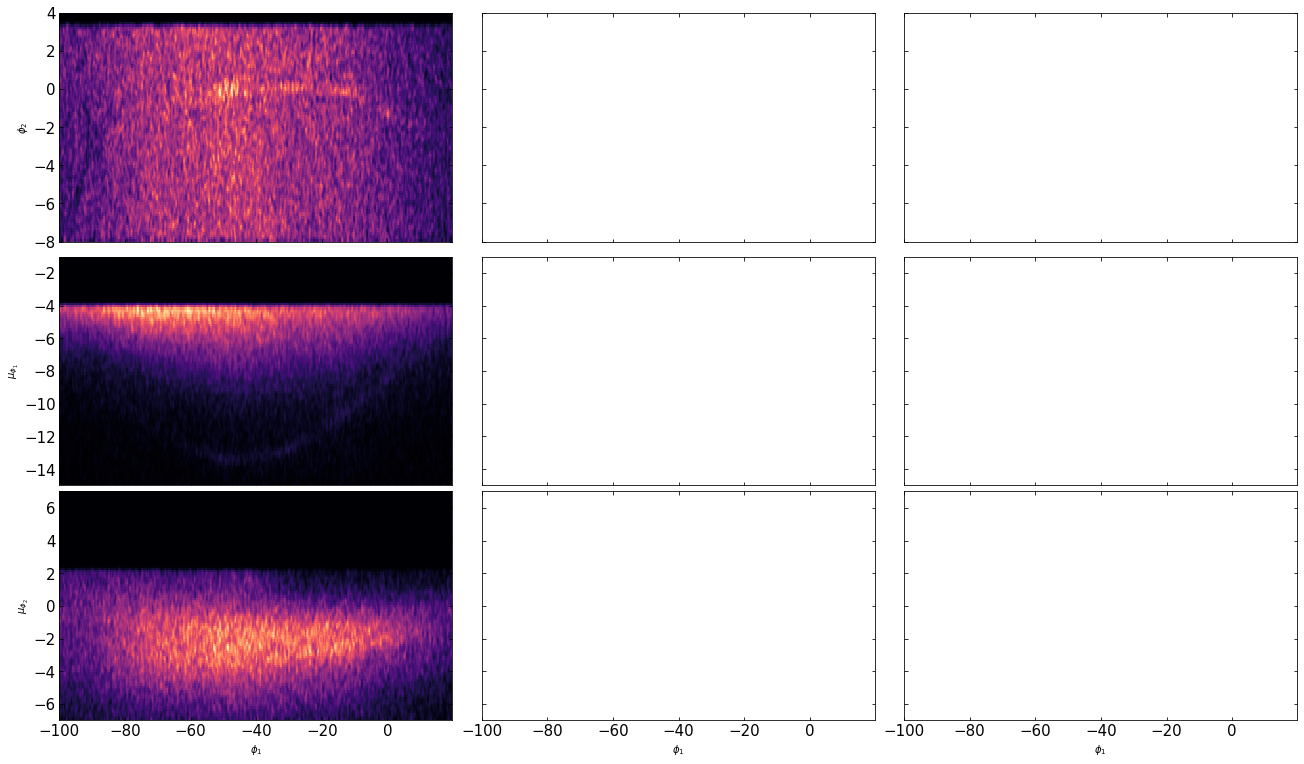

In [221]:
fig, axes = plt.subplots(
    len(stream_opt.coord_names) - 1,
    3, 
    figsize=(18, 3.5 * (len(stream_opt.coord_names) - 1)),
    sharex=True,
    sharey="row",
    constrained_layout=True,
)

axes = np.atleast_2d(axes)
plot_data_projections(
    data=run_data,
    grids=GD1Base.default_grids,
    axes=axes[:, 0],
)
full_mix_opt.plot_model_projections(axes=axes[:, 1])
full_mix_opt.plot_residual_projections(
    data=run_data, axes=axes[:, 2], pcolormesh_kwargs=dict(vmin=-1, vmax=1)
)

for ax in axes[-1]:
    ax.set_xlabel(r"$\phi_1$")